In [2]:
import torch
import argparse
import torchio as tio
import numpy as np
import nibabel as nib
from box import Box
import os.path as path
import torch
import sys, os, json
sys.path.append(os.path.join(sys.path[0], '../'))
from dataloader.patch_dataloader import patch_dataloader
from dataloader.data_utils_eval import (load_MRI_from_paths_list,
                                        load_mask_from_paths_list,
                                        get_filelist_from_path,
                                        default_mask_generation,
                                        apply_mask_to_subject)
from network.VNet_model import VNetModel

/home/dual4090/anaconda3/envs/3t7t/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/dual4090/anaconda3/envs/3t7t/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit 

In [3]:
def load_params(param_dir):
    with open(param_dir, 'r') as json_file:
        params = json.load(json_file)
    return Box(params)

In [4]:
param_path = '../../config/params_VNet_eval.json'
params = load_params(param_path)

In [5]:
print(params)

{'fp': {'subjects': '../../data/subjects.txt', 'filepaths': ['../../data/original'], 'postfixes': ['.nii.gz'], 'eval_modes': ['org', 'down2', 'down4'], 'ckpt_dir': '../../ckpts/tensorlog/VNet_final_ckpts', 'leave_out_subjects': []}, 'data': {'batch_size': 40, 'patch_size': 64, 'patch_overlap': 8}, 'training': {'num_workers': 32, 'max_queue_length': 1000, 'matmul_precision': 'medium', 'precision': '16-mixed'}, 'checkpoint': {'ckpt_dir': '../../ckpts/tensorlog'}}


In [6]:
empty_params = Box()

# Loading data

In [8]:
# input_3T_path = r'/home/dual4090/Downloads/Russell_T1.nii.gz'

input_3T_path = r'/home/dual4090/lab/github/3T-7T_registration/data/original/3T'
input_mask_path = r'/home/dual4090/lab/github/3T-7T_registration/data/original/mask/'



In [ ]:


input_3T_files = get_filelist_from_path(input_3T_path)
subjects_t1_3T = load_MRI_from_paths_list(input_3T_files, 't1_3T')
ids_subjects = sorted([s.id for s in subjects_t1_3T])
ids_missing_masks = []


if input_mask_path is None:
    print('No mask path provided, using default mask generation for post-processing')
    print('NOTE: this pipeline expects the images to be brain stripped!')
    input_mask_path = None
    subjects_mask = []
    ids_missing_masks = ids_subjects

if input_mask_path is not None:
    # load masks if provided
    input_mask_files = get_filelist_from_path(input_mask_path)
    subjects_mask = load_mask_from_paths_list(input_mask_files)
    ids_masks = sorted([s.id for s in subjects_mask])

    if ids_subjects != ids_masks:
        # checck if all subjects have a corresponding mask
        ids_missing_masks = list(set(ids_subjects) - set(ids_masks))
        print("id of subjects and masks do not match.\n" \
            f"missing masks for subjects {ids_missing_masks}\n"
            "using default mask generation for post-processing of these subjects")


In [13]:
subjects_missing_masks = [s for s in subjects_t1_3T if s.id in ids_missing_masks]
for subject_for_maskgen in subjects_missing_masks:
    generated_mask = default_mask_generation(subject_for_maskgen)
    subjects_mask.append(generated_mask)


In [20]:
subjects_dataset = tio.SubjectsDataset(apply_mask_to_subject(subjects_t1_3T, subjects_mask))

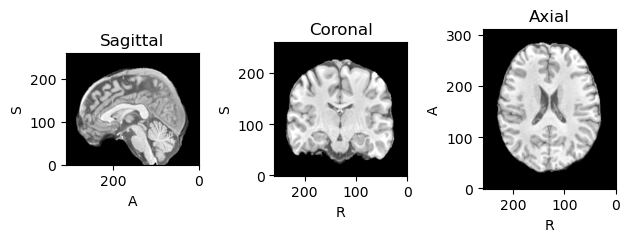

In [22]:
subjects_dataset[0].t1_3T.plot()

# Running Model

In [23]:
ckpt_path = r'/home/dual4090/lab/github/synth7T-MICCAI/ckpts/tensorlog/VNet_final_ckpts/MAEloss_finalmodel/Synthetic_7T_MRI_VNet_weights_updated.ckpt'

In [24]:
if not os.path.exists(ckpt_path):
    raise ValueError('Checkpoint path does not exist')

if not ckpt_path.endswith('.ckpt'):
    raise ValueError('Please provide a .ckpt file')

In [ ]:
model = VNetModel.load_from_checkpoint(ckpt_path).eval().to('cuda')

In [ ]:
batch_size = 40
patch_size = 64
patch_overlap = 8
num_workers = 1
max_queue_length = 1000

In [ ]:
params = {
    "data": {
            "batch_size": batch_size,
            "patch_size": patch_size,
            "patch_overlap": patch_overlap
    },
    "training":{ # this is a naming oversight, these are actually the parameters for the patched dataloader
                "num_workers": num_workers,
                "max_queue_length": max_queue_length
    }
}
params = Box(params)

In [43]:
params

Box({'data': {'batch_size': 10, 'patch_size': 64, 'patch_overlap': 8}, 'training': {'num_workers': 1, 'max_queue_length': 1000}})

In [44]:
with torch.no_grad():
    preds = []
    for subject in subjects_dataset:
        loader, aggregator = patch_dataloader(tio.SubjectsDataset([subject]), params)

        for patches_batch in loader:
            patches = patches_batch['t1_3T'][tio.DATA].to('cuda')
            locations = patches_batch[tio.LOCATION]
            patches_preds = model(patches) * patches_batch['mask'][tio.DATA].to('cuda')
            aggregator.add_batch(patches_preds.cpu(), locations)
        # get images from aggregators
        image = aggregator.get_output_tensor()
        affine = subject.t1_3T.affine  # same affine for images now, this may need change
        image = tio.ScalarImage(tensor=image, affine=affine)
        subject.add_image(image, 'pred')
        preds.append(subject)


In [ ]:
output_path = r'/home/dual4090/lab/github/3T-7T_registration/pred_3T7T'
if '.nii.gz' in output_path:
    output_dir = path.dirname(output_path)
else:
    output_dir = output_path
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
suffix = '_pred'
if len(preds) == 1:
    if os.path.isfile(output_dir) 
    output_path = path.join(output_dir, f'{preds[0].id}_pred.nii.gz')
    preds[0].pred.save(output_path)
    print(f'Saved {output_path}')

for subject in preds:
    
    output_path = path.join(output_dir, f'{subject.id}'+suffix+'.nii.gz')
    subject.pred.save(output_path)
    print(f'Saved {output_path}')

Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/06_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/04_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/9016_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/09_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/07_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/9015_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/10_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/03_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/05_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/08_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/01_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/02_pred.nii.gz
Saved /home/dual4090/lab/github/3T-7T_registration/pred_3T7T/9029_pred.nii.gz
Saved 

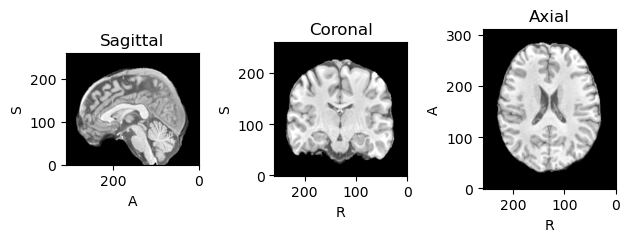

In [45]:
preds[0].t1_3T.plot()

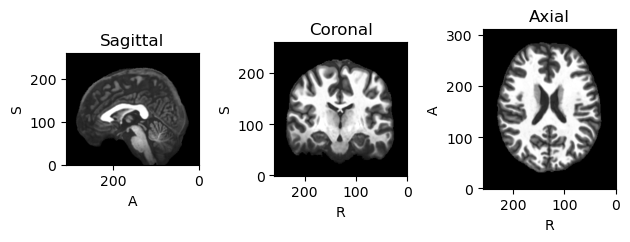

In [46]:
preds[0].pred.plot()